Authors: Antoine A. Ruzette, Simon F. Nørrelykke
Date: 2024-07-21

This notebook plots the correlation coefficients between cell pixel intensity and the signed distance to stroma for two partitions: inside a stromal region (distance < 0) and outside a stromal region (distance < 0) as defined by the modelled stromal border. It supports plotting results from parameter screens in QuPath. 

Contains the code to plot data from pNDRG1 images only. 

In [1]:
import os
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.pyplot import ScalarFormatter

# colorblind-friendly colors
CB_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']

Column names in the DataFrame after stripping whitespace:
Index(['TRITC FN', 'sigma', 'pearsonInsideStromaKer',
       'pearsonOutsideStromaKer', 'pearsonInsideStromaKerPNDRG1',
       'pearsonOutsideStromaKerPNDRG1', 'spearmanInsideStromaKer',
       'spearmanOutsideStromaKer', 'spearmanInsideStromaKerPNDRG1',
       'spearmanOutsideStromaKerPNDRG1'],
      dtype='object')


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_89984/1866475983.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sem_corr_sigma = grouped_sigma.apply(lambda x: pd.Series({
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_89984/1866475983.py:63: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sem_corr_FN_568 = grouped_FN_568.apply(lambda x: pd.Series({


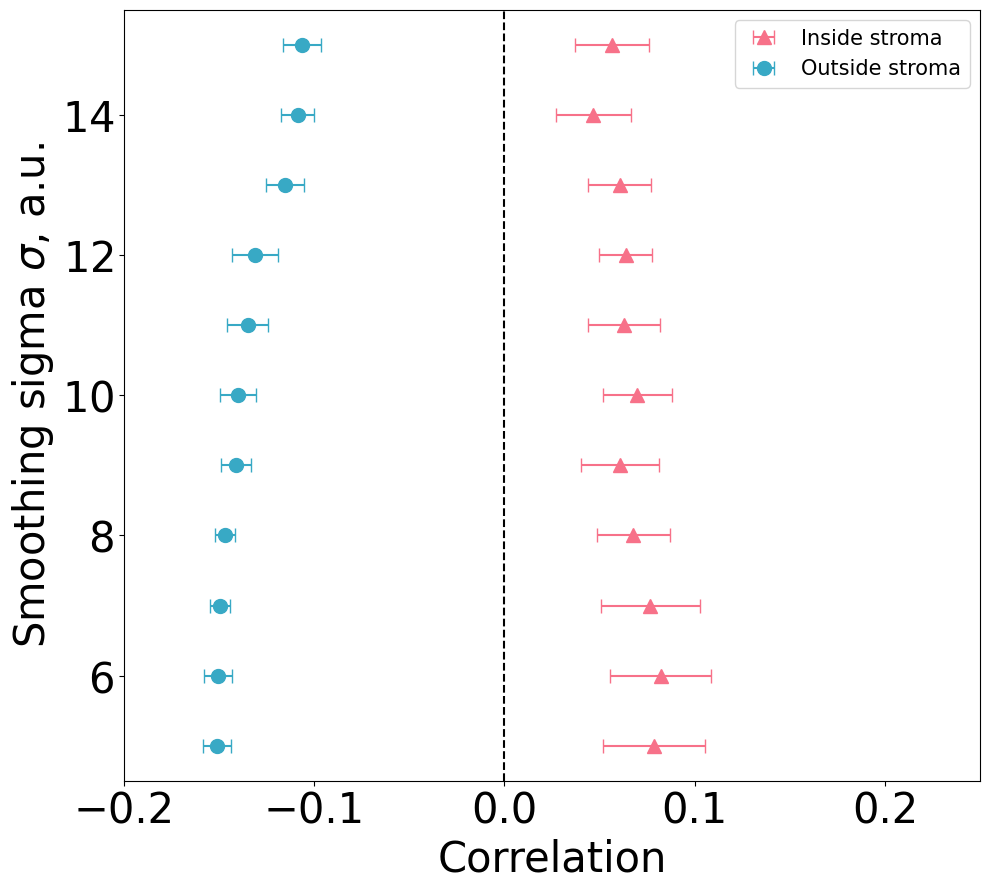

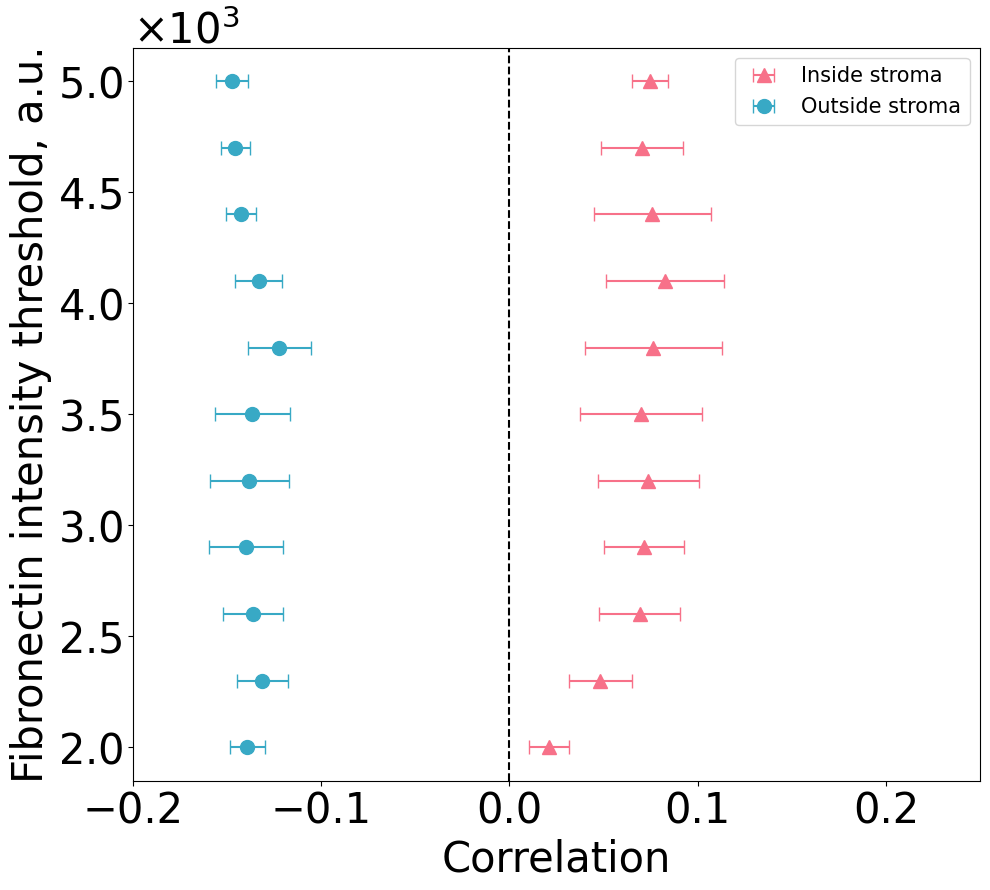

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def bootstrap_sem(data, n_bootstrap=500):
    """Calculate the standard error of the median using bootstrapping."""
    medians = [data.sample(frac=1, replace=True).median() for _ in range(n_bootstrap)]
    return np.std(medians)

# Path to the folder containing CSV files
folder_path = "/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/SUIT2_pNDRG1/results/sensitivity/20250311_sensitivity_s5-15_fn3000-5000"

# Get the list of CSV files
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Create color mapping for each CSV file
color_palette = sns.color_palette("husl", len(csv_files))
image_colors = {file: color for file, color in zip(csv_files, color_palette)}

# Initialize an empty list to store DataFrames
dfs = []

# Iterate over files in the folder
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        # Read CSV file and append to the list
        df = pd.read_csv(os.path.join(folder_path, file))
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
df_stroma = pd.concat(dfs, ignore_index=True)

# Remove leading/trailing whitespace from column names
df_stroma.columns = df_stroma.columns.str.strip()

# Print the column names to check
print("Column names in the DataFrame after stripping whitespace:")
print(df_stroma.columns)

# Check if the required columns are present
required_columns = ['pearsonInsideStromaKerPNDRG1', 'pearsonOutsideStromaKerPNDRG1']
for col in required_columns:
    if col not in df_stroma.columns:
        raise KeyError(f"Column {col} is not present in the DataFrame.")

# Group the data by 'sigma' and calculate the median
grouped_sigma = df_stroma.groupby('sigma')
avg_corr_sigma = grouped_sigma[['pearsonInsideStromaKerPNDRG1', 'pearsonOutsideStromaKerPNDRG1']].median()

# Calculate the SEM for each group using bootstrapping
sem_corr_sigma = grouped_sigma.apply(lambda x: pd.Series({
    'pearsonInsideStromaKerPNDRG1': bootstrap_sem(x['pearsonInsideStromaKerPNDRG1']),
    'pearsonOutsideStromaKerPNDRG1': bootstrap_sem(x['pearsonOutsideStromaKerPNDRG1'])
}))

# Group the data by 'FN_568' and calculate the median
grouped_FN_568 = df_stroma.groupby('TRITC FN')
avg_corr_FN_568 = grouped_FN_568[['pearsonInsideStromaKerPNDRG1', 'pearsonOutsideStromaKerPNDRG1']].median()

# Calculate the SEM for each group using bootstrapping
sem_corr_FN_568 = grouped_FN_568.apply(lambda x: pd.Series({
    'pearsonInsideStromaKerPNDRG1': bootstrap_sem(x['pearsonInsideStromaKerPNDRG1']),
    'pearsonOutsideStromaKerPNDRG1': bootstrap_sem(x['pearsonOutsideStromaKerPNDRG1'])
}))

# Create the first plot for 'sigma'
fig1, ax1 = plt.subplots(figsize=(10, 9))

# Plot data on the first plot with error bars
ax1.errorbar(avg_corr_sigma["pearsonInsideStromaKerPNDRG1"], avg_corr_sigma.index, xerr=sem_corr_sigma["pearsonInsideStromaKerPNDRG1"], fmt='^', color=color_palette[0], label='Inside stroma', markersize=10, capsize=5)
ax1.errorbar(avg_corr_sigma["pearsonOutsideStromaKerPNDRG1"], avg_corr_sigma.index, xerr=sem_corr_sigma["pearsonOutsideStromaKerPNDRG1"], fmt='o', color=color_palette[3], label='Outside stroma', markersize=10, capsize=5)
ax1.axvline(x=0, color='black', ls='--')
ax1.legend(prop={'size': 15}, loc='upper right')
ax1.set_xlim(-0.2, 0.25)

# Set the y-axis formatter to display scientific notation with a fixed number of decimals
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))
ax1.yaxis.set_major_formatter(formatter)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax1.tick_params(axis='both', which='minor', labelsize=30)
ax1.yaxis.get_offset_text().set_size(30)
ax1.yaxis.get_offset_text().set_fontsize(30)
ax1.yaxis.get_offset_text().set_color('black')

ax1.set_ylabel(r'Smoothing sigma $\sigma$, a.u.', fontsize=30)
ax1.set_xlabel('Correlation', fontsize=30)

plt.tight_layout()
plt.savefig('/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/SUIT2_pNDRG1/plots/pNDRG1_sensitivity_stroma_annotation_sigma.png', dpi=300)
plt.show()

# Create the second plot for 'FN_568'
fig2, ax2 = plt.subplots(figsize=(10, 9))

# Plot data on the second plot with error bars
ax2.errorbar(avg_corr_FN_568["pearsonInsideStromaKerPNDRG1"], avg_corr_FN_568.index, xerr=sem_corr_FN_568["pearsonInsideStromaKerPNDRG1"], fmt='^', color=color_palette[0], label='Inside stroma', markersize=10, capsize=5)
ax2.errorbar(avg_corr_FN_568["pearsonOutsideStromaKerPNDRG1"], avg_corr_FN_568.index, xerr=sem_corr_FN_568["pearsonOutsideStromaKerPNDRG1"], fmt='o', color=color_palette[3], label='Outside stroma', markersize=10, capsize=5)
ax2.axvline(x=0, color='black', ls='--')
ax2.legend(prop={'size': 15}, loc='upper right')
ax2.set_xlim(-0.2, 0.25)

# Set the y-axis formatter to display scientific notation with a fixed number of decimals
ax2.yaxis.set_major_formatter(formatter)
ax2.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='both', which='minor', labelsize=30)
ax2.yaxis.get_offset_text().set_size(30)
ax2.yaxis.get_offset_text().set_fontsize(30)
ax2.yaxis.get_offset_text().set_color('black')

ax2.set_ylabel('Fibronectin intensity threshold, a.u.', fontsize=30)
ax2.set_xlabel('Correlation', fontsize=30)

plt.tight_layout()
plt.savefig('/Users/antoine/Harvard/IAC/image_analysis_paper_QP_projects/SUIT2_pNDRG1/plots/pNDRG1_sensitivity_stroma_annotation_FN_568.png', dpi=300)
plt.show()
